In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve

import sympy as sym

%matplotlib inline
sns.set_style('whitegrid')


# Christmas notebook 1

This is the fisrt notebook in a series of three that will use the labour models as seen in Macro 1B to introduce some useful tools. These are all practice and of course not requiered for anything, but if you want to keep up with coding - as there are lots of coding to come in the coming months! - they are a relaxed way of refreshing the things we saw back in November. As such, I recommend keeping the other notebooks open to look up for code bits.

<img src=c_banner.png>

## Easy equation solver with the Shaphiro-Stiglitz model

Matlab has a special function called ``fsolve`` that solves simple equations of the form $f(x) = 0 $.

This come quite handy for simple univariate problems. The python equivalent is also called ``fsolve``. You can see how we import it unpstairs.

Actually, if you do have time to spare this Christmas, I recommend taking a look at all of the optimizations routines scipy offers [here](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html). Keep this page close, for we will use it later on when talking about estimation and function approximation.

Let's learn how to use fsolve with a familiar model: the Shaphiro-Stiglitz model.

### 1 Coding the Shaphiro-Stiglitz model

This is a warm up where you will use the same skills as in the Solow Model exercise and the Basics of python notebook. Keep one (or both) of this open for convenience.

Our objective here is to code a plot that shows the equilibrium of the model - and do some comparative statics.

> **Task 1**: Create a dictionary of parameters (call it ``pam``) with this baseline values:

|parameter|value|
|---|---|
|$z$ | 0.1|
|$e$ | 1|
|$q$ | 0.1|
|$\lambda$ | 0.1|
|$r$ | 0.03|
|$\alpha$ | 0.33|

In [15]:
# Parameters
pams = {"z" : 0.1,
        "e" : 1,
        "q" : 0.1,
        "lam":0.1,
        "r" : 0.03,
        "alpha":0.33}


K = 100
N = 100

We will also need to fix population of working age and capital:

In [3]:
K = 100
N = 100

> **Task 2**: In the cells bellow, define a function for each the two equations of the model, using the parameters declared above.

In case you forgot, those are:

Non-shrinking condition

$$w=z+e+\frac{e}{q}\Big[\frac{\lambda}{u}+r\Big]$$

Labour demand (assume Cobb-Douglas):

$$w=F'(L)$$

In [4]:
def NSC(u,params=pams):
    z, e, q, lam, r = params["z"], params['e'],params['q'],params['lam'],params['r']
    return z + e + (e/q) * (lam/u) + r * (e/q)

In [5]:
def Fl(L,K=K,alpha=pams['alpha'],A=10):
    return A*(K/L)**alpha*(1-alpha)

In [22]:
alpha, K, L, A = sym.var('alpha, K, L, A')    # define symbolic variables
Y = K**alpha * (A*L)**(1-alpha)
Y

K**alpha*(A*L)**(-alpha + 1)

In [19]:
def Fl(f):
    yl = f.diff("L")
    Fl = sym.lambdify((alpha, K, L, A), yl)
    return Fl

In [20]:
def Labor_demand(L,pams,f):
    Y = Fl(f)
    alpha=pams['alpha']
    K = 100
    A = 10
    return Y(alpha, K, L, A)
    

In [24]:
Labor_demand(5,pams=pams,f=Y)

8.421989609296247

In [9]:
Fl = sym.lambdify((alpha, K, L, A), Y)

Becuse we want a plot, we need a grid of values to feed the functions we defined above. The next cell defines a grid fou unemployment and employment ($L$).

There are a couple of ways to define a grid:
- ``np.linspace(a,b,n)`` creates a grid separated by splitting it in ``n`` even spaces between ``a`` and ``b``.

- ``np.arange(a,b,z)`` creates a grid between ``a`` and ``b`` in increments of ``z``.

- ``np.logspace(a,b)`` creates a grid between ``a`` and ``b`` in log increments. This means even spaces between $log_{10}(a)$ and $log_{10}(b)$. This is good for certains problems, specially if you are approximating a function that is exponential or logarithmic - this happens a lot.

For this problem, and depending how you defined the functions above, it is good to define a grid for unemployment (between 0 and 1) and a grid for employment (between 0 and $N$).

> **Task 3**: Define the a grid with 1000 points for unemployment ($u$), and another grid with its equivalent employment ($L$) level.

In [6]:
ugrid = np.linspace(1,0,1000)
Lgrid = N - ugrid*N

We are done! Use your defined functions, parameter dictionary and grid to plot the equilibrium of the model.

You should end up with somwthing that looks like my plot below:

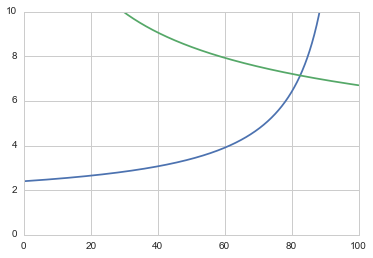

In [7]:
plt.plot(Lgrid,NSC(ugrid))
plt.plot(Lgrid,Fl(Lgrid))
plt.ylim(0,10)
plt.show()

### 2 A first look into optimization routines

Now we need to solve for the cross between the funtions: the equilibrium of the model.

You can work out the solution with pen and paper (and some algebra) but it is usually faster to use an *equation solver*.

Equation solvers are the small brothers of a family of optimizers (minimizers): functions that try to find the minimum of other functions. This usually involve get a function $f(x)$ as close to zero as it can.

Optimization theory is a whole topic in itself, and you will probably hear more about it in the bootcamp in June - where (spoliler alert) you'll code *your own* minimizer. If you want a quick review, I recommend again the [scipy website](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html) where all of these functions in python live.

The basic idea is super simple tough:
- Give an initial guess $x_0$ and calculate $f(x_0)$.
- Try an slightly bigger number $x_1 = x_0 + \Delta $ and caluclate $f(x_1)$
- Have we improved over $x_0$? Is $f(x_1)-f(x_0) < 0$?
    - If yes, then calculate $f(x_2) = f(x_1+\Delta)$ and repeat
    - If no, then calculate $f(x_{-1}) = f(x_0-\Delta)$ and repeat
    - If you get stuck between 2 points (say $x_4$ and $x_3$) then reduce the size of $\Delta$ and repeat
- When you get arbitrality close to 0, stop. You have solved the equation.

It's so simple it's silly, but that is what computers are best at: repeating very silly operations for an absurd ammount of times. When you hear people saying "I need to leave the computer running for days" they are usually running a very big optimization routine like the one above - think of a function of 16 variables, varying each of them in turn. Really, really stupid. But it works!

A bit of useful jargon:
- $x_0$ is the *initial guess* or *the guess*.
- $f$ is the *objective function*.
- $\Delta$ is the *step* or the *step size*.

Some clever minimization routines do more complicated stuff. For example, they adapt the step size, they jump to values very far away from the current guess if they see not a lot of progress of being made, they use "genetic permutations" (no kidding!) to find better guesses and a lot more. In general though, you can always be faster (and smarter) if your objective function happens to be differentiable - see [this](https://en.wikipedia.org/wiki/Newton's_method) for example.

For now, I will only teach you to use ``fsolve``, which is the name of the classic equation solver in Matlab. ``fsolve`` will return the value of $x$ such that $f(x)=0$. You need to define $x$ beforehand as a function of **one** variable and guive ``fsolve`` an initial guess.

This also leads me to a short cut to define functions in python: the ``lambda`` method:

In [8]:
polynomial = lambda x: x**2*3 - 4*x

Which is equivalent to:

In [9]:
def polynomial(x):
    return -x**2*3 + 4*x

And this is how you use fsolve to find the highest x for which ```polynomial = 0```:

In [10]:
fsolve(polynomial,10)

array([ 1.33333333])

We can check that it is the right point by plotting it the function:

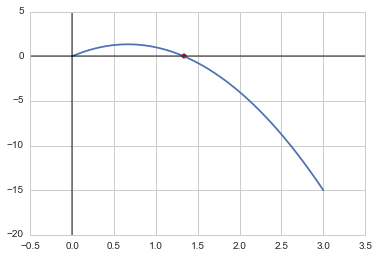

In [12]:
xgrid = np.linspace(0,3,100)                    # Create a grid for plotting
sol = fsolve(polynomial,10)                     # Store the solution in sol

plt.plot(xgrid,polynomial(xgrid))               # Plot the objective function
plt.scatter(sol,polynomial(sol),c='r')          # Mark the solution point ussing plt.scatter
plt.axhline(c='black',alpha=0.5)                # Plot a horizontal line (at 0 by default)
plt.axvline(c='black',alpha=0.5)                # Plot a vertical line (at 0 by default)
plt.show()                                      # Show the plot!

You should have noticed that I used 10 as an initial guess, which ensures I get the solution I wanted (the highest $x$ such that $f(x)=0$). But it is easy to see what could happen if instead I gave it a "bad" initial guess:

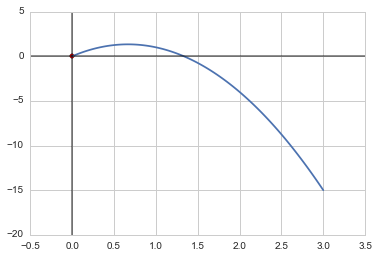

In [13]:
xgrid = np.linspace(0,3,100)                    # Create a grid for plotting
sol = fsolve(polynomial,0.2)                    # Store the solution in sol

plt.plot(xgrid,polynomial(xgrid))               # Plot the objective function
plt.scatter(sol,polynomial(sol),c='r')          # Mark the solution point ussing plt.scatter
plt.axhline(c='black',alpha=0.5)                # Plot a horizontal line (at 0 by default)
plt.axvline(c='black',alpha=0.5)                # Plot a vertical line (at 0 by default)
plt.show()                                      # Show the plot!

I ended up at $x=0$! Moral of the story: be careful with your initial guesses. 90% of being good at coding in economics is thinking about how to get a good initial guess.

Suposse we wanted to get the maximum of this function instead.

This alows me to introduce you to the ``poly1d`` module of ``numpy``. Watch:

In [14]:
poly = np.poly1d([-3, 4, 0])    # Define the coeffients in order (from bigger to smaller)
print poly                      # Prints (1) the order of the polynomial (2) the polynomial itself

    2
-3 x + 4 x


In [15]:
print poly.deriv()              # Prints the derivative of the polynomial

 
-6 x + 4


So convient, right?

Let's find the maximun now:

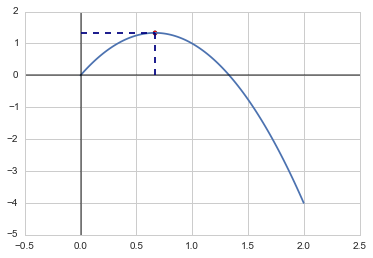

In [16]:
poly_derv = poly.deriv()                        # Create the objective function
xgrid = np.linspace(0,2,100)                    # Create a grid for plotting
sol = fsolve(poly_derv,0.2)                     # Store the solution in sol

plt.plot(xgrid,polynomial(xgrid))               # Plot the objective function
plt.scatter(sol,polynomial(sol),c='r')          # Mark the solution point ussing plt.scatter
plt.axhline(c='black',alpha=0.5)                # Plot a horizontal line (at 0 by default)
plt.axvline(c='black',alpha=0.5)                # Plot a vertical line (at 0 by default)

plt.plot( (sol,sol) , (0,poly(sol)) ,c='navy',ls='--')       # Plot a vertical line at optimum
plt.plot( (0,sol), (poly(sol),poly(sol)) ,c='navy',ls='--')  # Plot a horizontal line at optimum

plt.show()                                      # Show the plot!

### 3 Solving the S-T model

It's your turn now.

> **Task 4**: Create an equation that would serve as our objective function. Solve for the equilibirum level of $u$ and $L$
>
> *Hint: what should be zero in equilibrium?*

In [17]:
eq = lambda x : NSC(x) - Fl(N - x*N)

In [18]:
ueq = fsolve(eq,0.6)    # This gives me the solution in terms of unemployment

Leq = N - ueq*N         # Here I convert to employment
print ueq

[ 0.174303]


> **Task 5**: Add the equilibrium value to your plot from above (task 3). 

Should look like mine below:

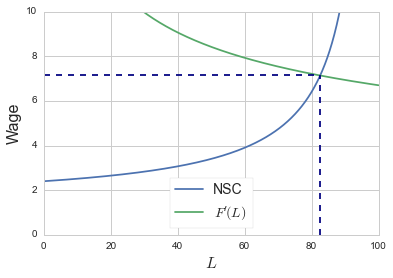

In [19]:
plt.plot(Lgrid,NSC(ugrid), label='NSC')                        # Plots NSC
plt.plot(Lgrid,Fl(Lgrid), label="$F'(L)$")                     # Plots Labour demand
plt.plot( (Leq,Leq), (0,NSC(ueq)), ls='--', c='navy')          # Plots vertical line to equilibrium (x1,x2),(y1,y2)
plt.plot( (0,Leq), (NSC(ueq),NSC(ueq)), ls='--' , c='navy')    # Plots horizaontal line to equilibrium
plt.xlabel("$L$", fontsize=16)                                 # Labels x axis
plt.ylabel('Wage', fontsize=16)                                # Labels y axis
plt.legend(loc='best',frameon=True,fontsize=14)                # Plots the legend
plt.ylim(0,10)                                                 # Sets plot limits
plt.show()                                                     # Show the plot!

### 4 Comparative statics

Let's increase the exogenous job destruction rate.

> **Task 6:** Change the parameter $\lambda$ to be equal to $0.2$. Calculate the new equilibrium unemployment and plot the result.
>
> Extra points if you plot the previous line with the new one in the same picture.
>
> *Hint: remember to copy the dictionary instead of modifying the original*

In [20]:
pam2 = pams.copy()          # Create a new dictionary (copy of the old one)
pam2['lam'] = 0.2           # Change the value of lambda 

# Solve again for equilibrium: define your objective
eq2 = lambda x : NSC(x,params=pam2) - Fl(N - x*N, alpha=pam2['alpha'])

#Â Solve again for equilibrium: feed it to the equation solver
ueq2 = fsolve(eq2,0.6)

Leq2 = N - ueq2*N          # Convert to employment
print ueq2                 # Print the result

[ 0.32175847]


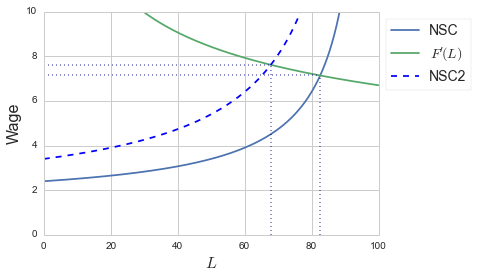

In [35]:
plt.plot(Lgrid,NSC(ugrid), label='NSC')
plt.plot(Lgrid,Fl(Lgrid), label="$F'(L)$")
plt.plot(Lgrid,NSC(ugrid,pam2), label='NSC2', c='blue', ls='--')

plt.plot( (Leq2,Leq2), (0,NSC(ueq2,params=pam2)), ls=':', c='navy', alpha=0.5)
plt.plot( (0,Leq2), (NSC(ueq2,params=pam2),NSC(ueq2,params=pam2)), ls=':' , c='navy', alpha=0.5)
plt.plot( (Leq,Leq), (0,NSC(ueq)), ls=':', c='navy', alpha=0.5)
plt.plot( (0,Leq), (NSC(ueq),NSC(ueq)), ls=':' , c='navy', alpha=0.5)
plt.xlabel("$L$", fontsize=16)
plt.ylabel('Wage', fontsize=16)
plt.legend(loc='best',frameon=True,fontsize=14,bbox_to_anchor=(1,1))
plt.ylim(0,10)
plt.show()

Can you calculate the elasticity of unemployment to the job destruction rate (j.d.r.)? Remember the formula of elasticity:

$$\epsilon^u_\lambda =  \frac{d u}{d \lambda}  \frac{\lambda}{u} = \frac{\frac{du}{u}}{\frac{d\lambda}{\lambda}}$$

So it's relative change in unemployemnt over relative change in j.d.r.

In [44]:
l1 = pams['lam']
l2 = pam2['lam']
print "Elasticity is {}".format(float( ((ueq2-ueq)/ueq)/((l2-l1)/l1) ))

Elasticity is 0.84597209019


## Done!

This was a cute fun exercise that show you how to use a simple equation solver. Hopefull you have also gained some basic intuition into how the computer works its magic when using optimization routines.

For papers and presentations most of what you'll need is to produce plots and tables of summary statistics (like elasticities). These silly exercises areactually good practice, and maybe even good to keep at hand for future exercises. I'll upload my solutions by the end of the week.

If you want more practice try changing other paramters in the cells bellow, or calculate more elasticities, fell free to use the cells below.

## Next week

Introduction to numerical integration with the MacCall model!

## <span style="color:red">Merry Christmas everybody!</span>
<a href="http://www.theatlantic.com/business/archive/2013/12/if-economists-wrote-christmas-cards/282493/"> 
<img src="https://lh3.googleusercontent.com/-pzas1Rsj5K4/Vn0-w_vlvLI/AAAAAAAAL7E/YCiqwcruYxc/s0/holiday-octocat.png",width=200,height=200>  </a>